In [6]:
cd /opt/app

/opt/app


In [8]:
! ls /opt/data/cat_dog_coco/

annotations  images


In [5]:
! ls /opt/data/cat_dog_coco/annotations

annotations.json


In [9]:
! ls /opt/data/cat_dog_coco/images

000000001319.jpg  000000136373.jpg  000000273885.jpg  000000476173.jpg
000000018155.jpg  000000161617.jpg  000000283471.jpg  000000499656.jpg
000000033111.jpg  000000168963.jpg  000000306395.jpg  000000516194.jpg
000000053289.jpg  000000177529.jpg  000000342150.jpg  000000531983.jpg
000000055607.jpg  000000179392.jpg  000000344702.jpg  000000532975.jpg
000000086205.jpg  000000183757.jpg  000000349776.jpg  000000557543.jpg
000000116503.jpg  000000209419.jpg  000000381605.jpg  000000562458.jpg
000000117108.jpg  000000220053.jpg  000000396039.jpg  000000570995.jpg


In [15]:
%%file /opt/configs/faster_rcnn/cat_dog.py

_base_ = [
    '../_base_/models/faster_rcnn_r50_fpn.py',
    '../_base_/datasets/coco_detection.py',
    '../_base_/schedules/schedule_1x.py', '../_base_/default_runtime.py'
]
checkpoint_config = dict(interval=18)
log_config = dict(
    interval=3000,
    hooks=[
        dict(type='TextLoggerHook'),
        # dict(type='TensorboardLoggerHook')
    ])
model = dict(
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch'),
    # neck=dict(type='DensityFPN'),
    rpn_head=dict(
        type='RPNHead',
        # adaptive=False,
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[4],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[.0, .0, .0, .0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        # loss_density=dict(type='MSELoss', reduction='mean', loss_weight=0.01),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.0),
        loss_bbox=dict(type='SmoothL1Loss', beta=1.0 / 9.0, loss_weight=1.0)),

    roi_head=dict(
        type='TailRoIHead',
        labels_tail=[2, 4, 5, 6, 7, 8, 9],
        labels=[0, 1, 3],
        bbox_roi_extractor=dict(
            type='SingleRoIExtractor',
            roi_layer=dict(type='RoIAlign', out_size=7, sample_num=0),
            out_channels=256,
            featmap_strides=[4, 8, 16, 32]),
        bbox_head_tail=dict(
            type='TailBBoxHead',
            in_channels=256,
            fc_out_channels=1024,
            roi_feat_size=7,
            num_classes=2,
            bbox_coder=dict(
                type='DeltaXYWHBBoxCoder',
                target_means=[0., 0., 0., 0.],
                target_stds=[0.1, 0.1, 0.2, 0.2]),
            reg_class_agnostic=False,
            loss_cls=dict(
                type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0),
            loss_bbox=dict(type='L1Loss', loss_weight=1.0)),
        bbox_head=dict(
            type='TailBBoxHead',
            in_channels=256,
            fc_out_channels=1024,
            roi_feat_size=7,
            num_classes=2,
            bbox_coder=dict(
                type='DeltaXYWHBBoxCoder',
                target_means=[0., 0., 0., 0.],
                target_stds=[0.1, 0.1, 0.2, 0.2]),
            reg_class_agnostic=False,
            loss_cls=dict(
                type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0),
            loss_bbox=dict(type='L1Loss', loss_weight=1.0))))
test_cfg = dict(
    rpn=dict(
        nms_across_levels=False,
        nms_pre=1000,
        nms_post=1000,
        max_num=1000,
        nms_thr=0.7,
        min_bbox_size=0),
    rcnn=dict(
        score_thr=0.05, nms=dict(type='nms', iou_thr=0.5), max_per_img=500))
# dataset settings
dataset_type = 'CocoDataset'
classes = ('cat', 'dog')
data_root = '/opt/data/cat_dog_coco/'
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(
        type='MinIoURandomCrop',
        min_ious=(0.1, 0.3, 0.5, 0.7, 0.9),
        min_crop_size=0.3),
    dict(type='Resize', img_scale=[(1000, 600)], keep_ratio=True),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='Normalize', **img_norm_cfg),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels']),
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=[(1000, 600)],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **img_norm_cfg),
            dict(type='Pad', size_divisor=32),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),

        ])
]
train_cfg = dict(
    rpn=dict(
        assigner=dict(
            type='MaxIoUAssigner',
            pos_iou_thr=0.7,
            neg_iou_thr=0.3,
            min_pos_iou=0.3,
            match_low_quality=True,
            ignore_iof_thr=-1),
        sampler=dict(
            type='RandomSampler',
            num=256,
            pos_fraction=0.5,
            neg_pos_ub=-1,
            add_gt_as_proposals=False),
        allowed_border=-1,
        pos_weight=-1,
        debug=False),
    rpn_proposal=dict(
        nms_across_levels=False,
        nms_pre=2000,
        nms_post=1000,
        max_num=1000,
        nms_thr=0.7,
        min_bbox_size=0),
    rcnn=dict(
        assigner_tail=dict(
            type='MaxIoUAssigner',
            pos_iou_thr=0.5,
            neg_iou_thr=0.5,
            min_pos_iou=0.5,
            match_low_quality=False,
            ignore_iof_thr=-1),
        sampler_tail=dict(
            type='RandomSampler',
            num=512,
            pos_fraction=0.5,
            neg_pos_ub=-1,
            add_gt_as_proposals=True,
            labels=[2, 4, 5, 6, 7, 8, 9]),

        assigner=dict(
            type='MaxIoUAssigner',
            pos_iou_thr=0.5,
            neg_iou_thr=0.5,
            min_pos_iou=0.5,
            match_low_quality=False,
            ignore_iof_thr=-1),
        sampler=dict(
            type='RandomSampler',
            num=512,
            pos_fraction=0.25,
            neg_pos_ub=-1,
            add_gt_as_proposals=True,
            labels=[0, 1, 3]),
        pos_weight=-1,
        debug=False))
data = dict(
    samples_per_gpu=2,
    workers_per_gpu=2,
    train=dict(
        type=dataset_type,
        classes=classes,
        ann_file=data_root + 'annotations/annotations.json',
        img_prefix=data_root + 'images/',
        pipeline=train_pipeline),
    val=dict(
        type=dataset_type,
        classes=classes,
        ann_file=data_root + 'annotations/annotations.json',
        img_prefix=data_root + 'images/',
        pipeline=test_pipeline),
    test=dict(
        type=dataset_type,
        classes=classes,
        ann_file=data_root + 'annotations/annotations.json',
        img_prefix=data_root + 'images/',
        pipeline=test_pipeline))
evaluation = dict(interval=1, metric='bbox')
optimizer = dict(type='SGD', lr=0.002, momentum=0.95, weight_decay=5 * 1e-4)
lr_config = dict(
    policy='step',
    warmup='linear',
    warmup_iters=500,
    warmup_ratio=1.0 / 3,
    step=[8, 12, 16])
total_epochs = 18
load_from = '/opt/notebooks/vd_faster_rcnn_r50_fpn_tail_epoch_18.pth'

Overwriting /opt/configs/faster_rcnn/cat_dog.py


In [13]:
! ls /opt/notebooks

cat_dog.ipynb  test_image.jpg  vd_faster_rcnn_r50_fpn_tail_epoch_18.pth


In [4]:
from pathlib import Path
from PIL import Image
import requests

In [5]:
myfile = requests.get("https://stmedia.stimg.co/ows_157782178985657.jpg?fit=crop&crop=faces", allow_redirects=True)
Path("test_image.jpg").open('wb').write(myfile.content)

229757

In [7]:
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
import mmcv

/opt/conda/lib/python3.7/site-packages/mmcv/utils/registry.py:64: UserWarning: The old API of register_module(module, force=False) is deprecated and will be removed, please use the new API register_module(name=None, force=False, module=None) instead.
  'The old API of register_module(module, force=False) '


In [8]:
config_file = '/opt/configs/faster_rcnn/cat_dog.py'
checkpoint_file = '/opt/app/checkpoints/cat_dog/latest.pth'

In [9]:
model = init_detector(config_file, checkpoint_file, device='cuda:0')

/opt/conda/lib/python3.7/site-packages/mmcv/utils/misc.py:304: UserWarning: "out_size" is deprecated in `RoIAlign.__init__`, please use "output_size" instead
  f'"{src_arg_name}" is deprecated in '
/opt/conda/lib/python3.7/site-packages/mmcv/utils/misc.py:304: UserWarning: "sample_num" is deprecated in `RoIAlign.__init__`, please use "sampling_ratio" instead
  f'"{src_arg_name}" is deprecated in '


In [11]:
img = '/opt/notebooks/test_image.jpg'
result = inference_detector(model, img)

/opt/conda/lib/python3.7/site-packages/mmcv/utils/misc.py:304: UserWarning: "iou_thr" is deprecated in `nms`, please use "iou_threshold" instead
  f'"{src_arg_name}" is deprecated in '


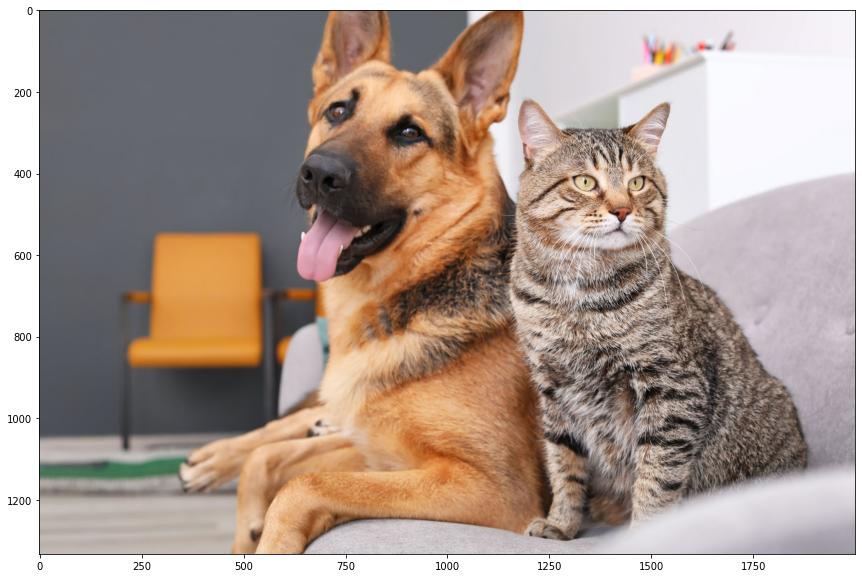

In [12]:
show_result_pyplot(model, img, result)